Notebook Done by Jeremy

# Imports

In [1]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
import statsmodels as st
import statsmodels.api as sm
from scipy import stats
from pandas import DataFrame
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from dateutil.parser import parse
import scipy.stats as scs
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams

#Stop warnings
import warnings
warnings.filterwarnings("ignore")


# Read Data

In [2]:
def read_CLEAN_data(filename):
    #Read in CSV file
    dat = pd.read_csv(filename)
    #Convert datetimes
    dat["Date"] = pd.to_datetime(dat["Date"], format = '%Y-%m-%d').dt.date
    
    return dat
# 10 hours of non zeroes 
def adherence_check1(df):
  df1 = df.copy()
  df1['Not Zero'] = df1['Steps'] > 0
  df1 = df1.groupby('Date').sum()
  df1 = df1['Not Zero'] > 10 
  return df1

#Greater than 500 steps
def adherence_check2(df,min):
  df1 = df.copy()
  df1 = df1.groupby('Date').sum()
  df1 = df1['Steps']> min
  return df1 

#Active in 3 time blocks 
def adherence_check3(df):
  df1 = df.copy()
  bins = [-1,2,10,14,25,np.inf]
  names = ['3','1','2', '3', '3']
  df1['3timeblock'] = pd.cut(df1['Hour'],bins, labels = names, ordered=False)
  df1 = df1.groupby(['Date','3timeblock'], as_index=False)['Steps'].sum()
  df1['Steps within timeblock'] = df1['Steps']> 0 
  df1 = df1.groupby('Date').sum()
  df1 = df1['Steps within timeblock'] ==3 
  return df1

#Combining it all into 1 dataframe
def three_method_table(x):
  valid_1= adherence_check1(x)
  valid_2= adherence_check2(x,500)
  #valid_3= adherence_check3(x)
  #result = pd.concat([valid_1,valid_2,valid_3], axis=1, join='inner')
  result = pd.concat([valid_1,valid_2], axis=1, join='inner')
  result.reset_index(level=0, inplace=True)
  #result.columns = ["Date", "10 Hours Non Zero","Steps > 500","3 Timeblock"]
  result.columns = ["Date", "10 Hours Non Zero","Steps > 500"]
  #result['All 3 True'] = result["3 Timeblock"]*result["10 Hours Non Zero"]*result["Steps > 500"]
  result['All 3 True'] = result["10 Hours Non Zero"]*result["Steps > 500"]
  result_sum = result.sum()
  return result , result_sum

def filter_by_adherence(df, measure):
    df2 = three_method_table(df)[0]
    df3 = df.merge(df2,on ='Date')
    if(measure == 1):
        mask = (df3['10 Hours Non Zero'] == True)
    elif(measure == 2):
        mask = (df3['Steps > 500'] == True)
    elif(measure == 3):
        mask = (df3['All 3 True'] == True)
    filtered_df = df3.loc[mask].drop(['10 Hours Non Zero', 'Steps > 500', 'All 3 True'], axis=1)
    #filtered_df = filtered_df.drop('index', axis=1)
    return filtered_df

# Method 1 calculates daily steps based on all the step acitivity that is available during the day
def run_method_1(df):
    
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

# Method 2 calculates daily steps based on the 10 most active hours of the day
def run_method_2(df):
    
    df = df.sort_values(by=["Date", "Steps"], ascending=False).groupby('Date').head(10)
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

# Method 3 calculates daily steps based on a 10 hour time block during the day
def run_method_3(df, start_hour, end_hour):
    
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    mask = (df['Hour'] >= start_hour) & (df['Hour'] <= end_hour)
    df = df.loc[mask]
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

def calculate_daily_steps(file_name, filter_measure, start_time, end_time):
    
    df = read_CLEAN_data(filename)
    filtered_df = filter_by_adherence(df, filter_measure)
    
    dailysteps_method2 = run_method_2(filtered_df)
    dailysteps_method1 = run_method_1(filtered_df)
    dailysteps_method3 = run_method_3(filtered_df, start_time, end_time)
    
   
    return dailysteps_method1,dailysteps_method2,dailysteps_method3
   
    

In [3]:
filename = "../../../data/cleaned/Participant3.csv"

filter_measure = 2
start_time = 8
end_time = 18

ds_method1, ds_method2, ds_method3 = calculate_daily_steps(filename, filter_measure, start_time, end_time)


In [4]:
ds_method1.set_index('Date',inplace=True)
ds_method1.shape

(1043, 1)

# Method 1

# Steps to take to implement (S)ARIMA

1) Check for Seasonality <br />
2) Check for Stationarity <br />
3) If not Stationary perform Rolling/ Smoothing/ Shifting/ Differentiation <br />
4) Obtain SARIMA Parameters <br />
5) Data Splitting and Model evaluation by plots <br />
6) Data Forecasting


### 1) Check For Seasonality

##### Simple Plot

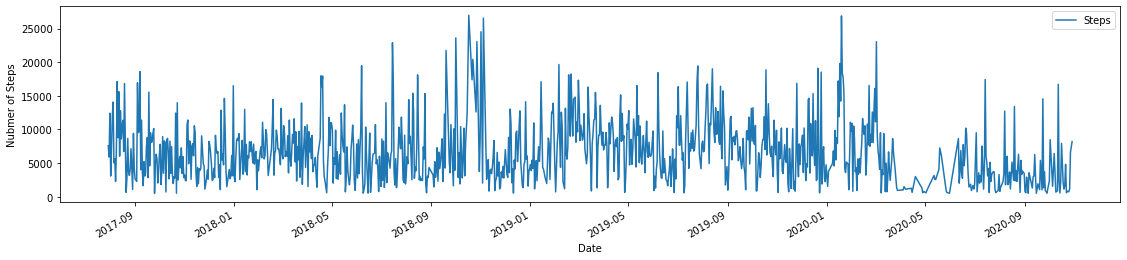

In [6]:
ds_method1.plot(figsize=(19, 4))
plt.ylabel("Nubmer of Steps")
plt.show()

#### Seasonal Decompose Plot

Using the command, we can decompose the time series into three distinct components: Trend, Seasonality and noise

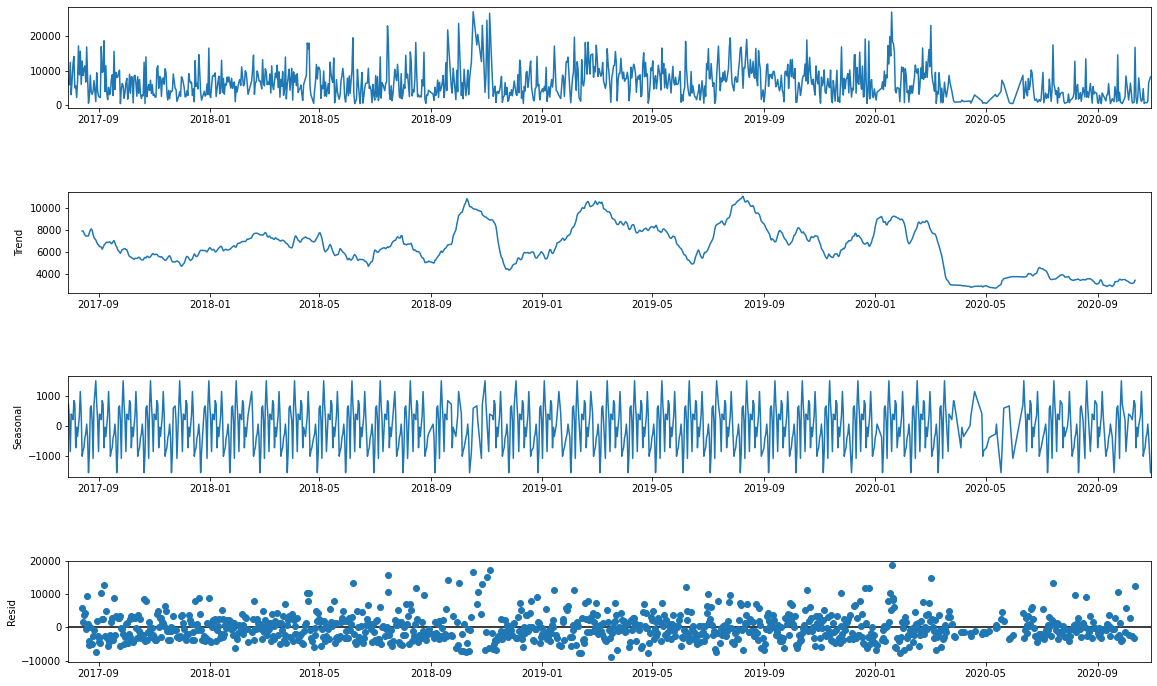

In [7]:
decomposition = sm.tsa.seasonal_decompose(ds_method1, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

After adherence, it appears that the data does have some form of Seasonality over the years besides certain year-gaps. As such, we will employ the SARIMA here instead of ARMIA

# Check for data Stationarity

Will use this function to test for stationarity by using the **Augmented Dickey-Fuller test**

where <br />
$H_0$: If failed to be rejected, time series data is not stationary <br />
$H_1$: If $H_0$ is rejected, it means the time series data is stationary

In [8]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel("Date")
    plt.ylabel("Number of Steps")
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Steps'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

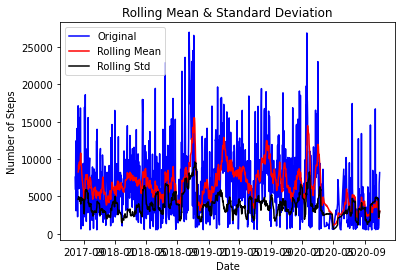

Results of Dickey Fuller Test:
ADF Test Statistic            -6.328102e+00
p-value                        2.952017e-08
#Lags Used                     1.100000e+01
Number of Observations Used    1.031000e+03
Critical Value (1%)           -3.436709e+00
Critical Value (5%)           -2.864347e+00
Critical Value (10%)          -2.568265e+00
dtype: float64


In [9]:
test_stationarity(ds_method1)

For this, we will use the $\alpha$ value of 0.05 to check against the p-value of 2.952017e-08 to decide if we will accept or reject the $H_0$. As $\alpha$ > p-value, we can conclude that the data is stationary.

## Making Data Stationary

As the data is stationary, we do not need to perform any transformation of the data to achieve stationarity.

### Data Transformation to acheive Normality

#### Log Transformation

In [10]:
#Estimating trend
#ds_method1 = np.log(ds_method1)
#plt.plot(ds_method1)

# (S)ARIMA Parameters

#### ACF and PACF plots

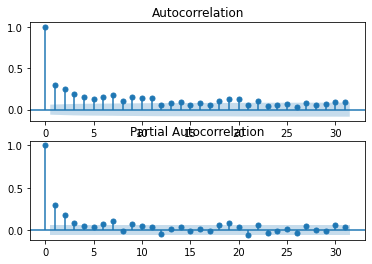

In [11]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method1, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method1, ax=ax[1])
plt.show()

Using PACF, p = 3, d = 0

In [14]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(ds_method1, start_p=0, start_q=0,
                           max_p=2, max_q=3, m=12,
                           start_P=0,start_Q=0, seasonal=True,
                           d=0, D=0, max_P = 10, max_Q = 10, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=20508.224, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=20413.784, Time=0.26 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=20442.471, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=21709.402, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=20411.785, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=20413.783, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=20415.783, Time=0.72 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=20381.365, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=20382.764, Time=0.36 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=20382.747, Time=0.18 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=20381.005, Time=0.11 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=20381.904, Time=0.42 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=20382.479, Time=0.26 sec
 ARIMA(2,0,

So, the best set of paramters to select is  **ARIMA(2,0,1)(2,0,1)[12]** I selected m = 12 to represent the yearly number of months each 'season' runs for 

Optimization terminated successfully.
         Current function value: 9.760723
         Iterations: 6
         Function evaluations: 475


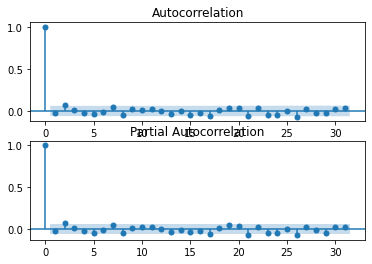

In [16]:
model = sm.tsa.statespace.SARIMAX(ds_method1, order=(2,0,1), seasonal_order = (2,0,1,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, ax=ax[1])
plt.show()

In [17]:
train = ds_method1.loc['2017-07-30':'2020-01-10']
test = ds_method1.loc['2020-01-11':]
stepwise_model.fit(train)

ARIMA(order=(2, 0, 1), scoring_args={}, seasonal_order=(2, 0, 1, 12),
      suppress_warnings=True)

In [18]:
mod = sm.tsa.statespace.SARIMAX(ds_method1,
                                order=(2, 0, 1),
                                seasonal_order=(2, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Steps   No. Observations:                 1043
Model:             SARIMAX(2, 0, 1)x(2, 0, 1, 12)   Log Likelihood               -9933.467
Date:                            Sun, 15 Nov 2020   AIC                          19880.933
Time:                                    00:35:27   BIC                          19915.406
Sample:                                         0   HQIC                         19894.025
                                           - 1043                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0813      0.050     21.720      0.000       0.984       1.179
ar.L2         -0.1120      0.039   

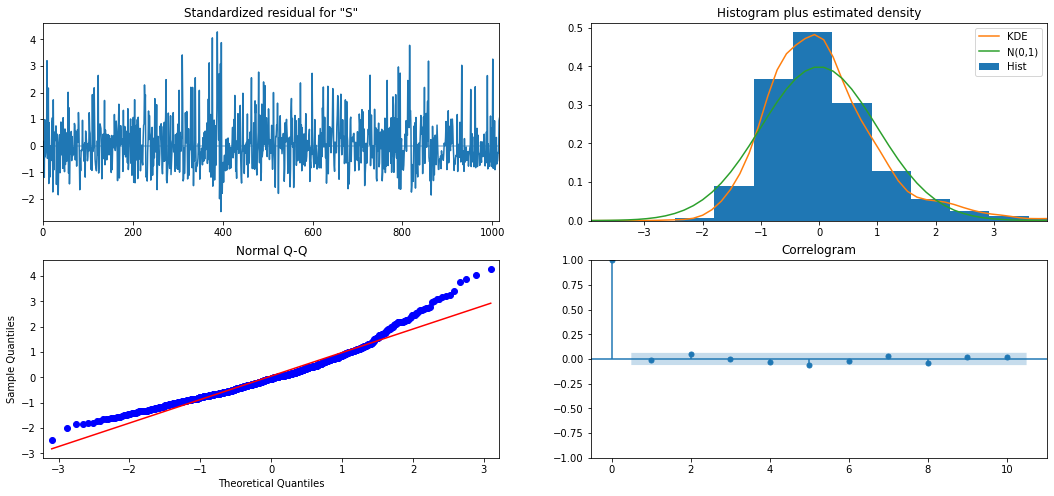

In [19]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

### (S)ARIMA Model Validation

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error 

Train Set 80%, Validation 20%

In [21]:
# the 20% point test data is on the specified date below
split_date = '2020-01-10'
data = ds_method1['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(2, 0, 1),
                                seasonal_order=(2, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [22]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae1 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse1 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse1 = math.sqrt(mse1)
print(f'Mean Squared Error: {mse1.round(4)}')
print(f'Root Mean Squared Error: {round(rmse1,4)}')
print(f'Mean Absolute Error: {mae1.round(4)}')

Mean Squared Error: 26891781.6237
Root Mean Squared Error: 5185.7286
Mean Absolute Error: 4410.0606


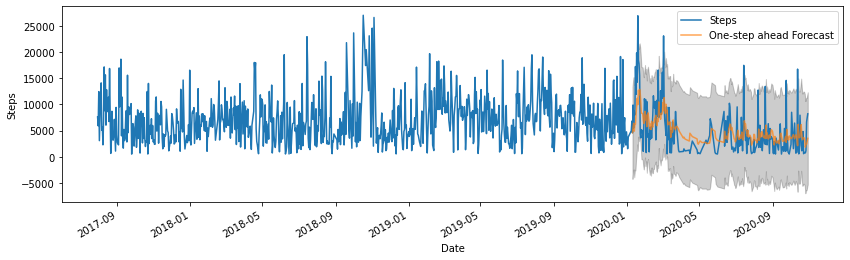

In [23]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-10'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method1['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Steps')
plt.legend()
plt.show()

# Method 2

In [24]:
#method_1.set_index('Date',inplace=True)
ds_method2.set_index('Date',inplace=True)
ds_method2.head()

,Steps
Date,
2017-07-30,7582.427320
2017-07-31,5903.087652
2017-08-01,12335.158512
2017-08-02,3063.008540
2017-08-03,7027.358587


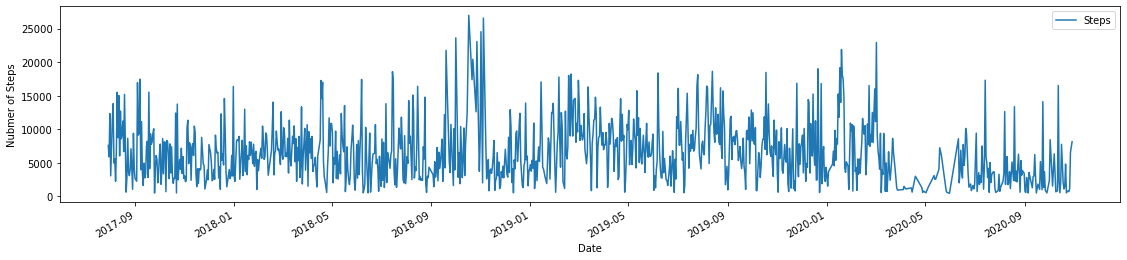

In [25]:
ds_method2.plot(figsize=(19, 4))
plt.ylabel("Nubmer of Steps")
plt.show()

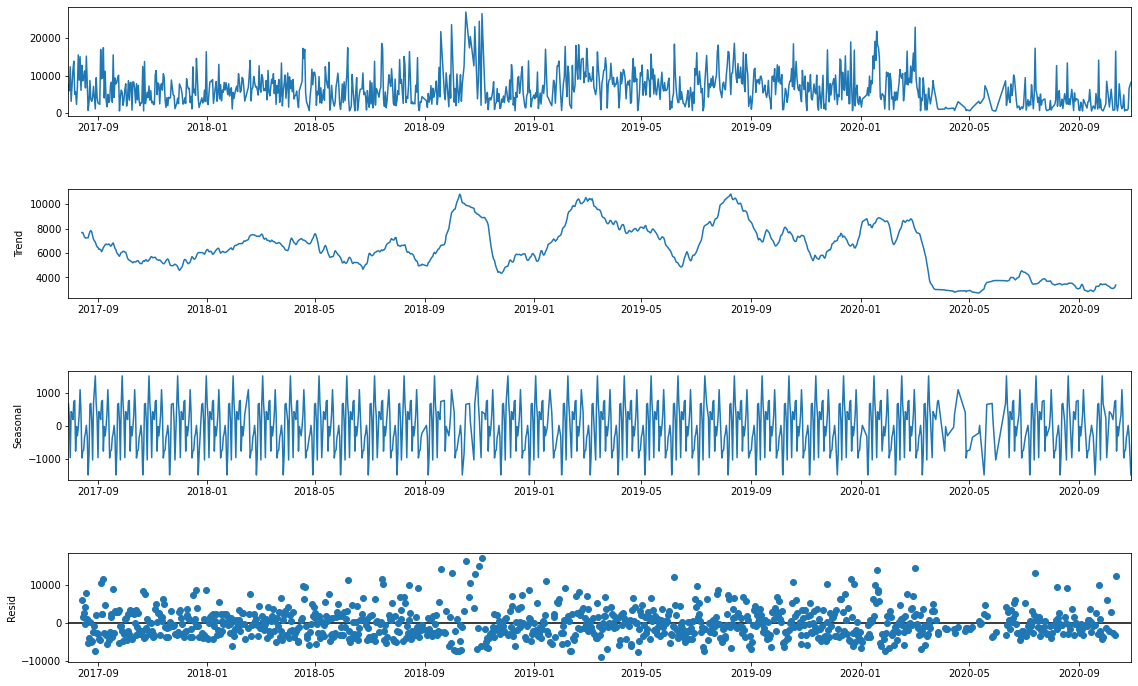

In [26]:
decomposition = sm.tsa.seasonal_decompose(ds_method2, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

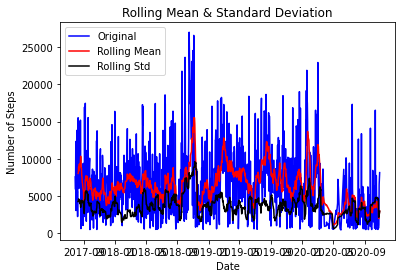

Results of Dickey Fuller Test:
ADF Test Statistic               -4.299175
p-value                           0.000446
#Lags Used                       21.000000
Number of Observations Used    1021.000000
Critical Value (1%)              -3.436771
Critical Value (5%)              -2.864375
Critical Value (10%)             -2.568279
dtype: float64


In [27]:
test_stationarity(ds_method2)

Again, data appears to be stationary so no transformation of the data was required.

In [28]:
#Estimating trend
#ds_method2 = np.log(ds_method2)
#plt.plot(ds_method2)

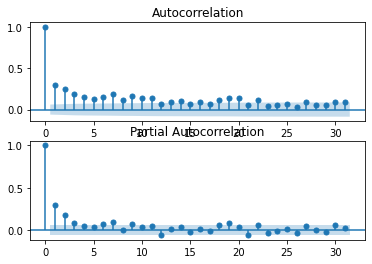

In [29]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method2, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method2,ax=ax[1])
plt.show()

In [32]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(ds_method2, start_p=0, start_q=0,
                           max_p=2, max_q=10, m=12,
                           start_P=0,start_Q=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=20450.291, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=20355.083, Time=0.30 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=20384.360, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=21667.040, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=20353.095, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=20355.080, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=20357.080, Time=0.74 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=20321.378, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=20322.609, Time=0.45 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=20322.591, Time=0.20 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=20324.562, Time=0.92 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=20320.830, Time=0.11 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=20321.480, Time=0.41 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=20322.152, Time=0.29 sec
 ARIM

Optimization terminated successfully.
         Current function value: 9.725330
         Iterations: 2
         Function evaluations: 170


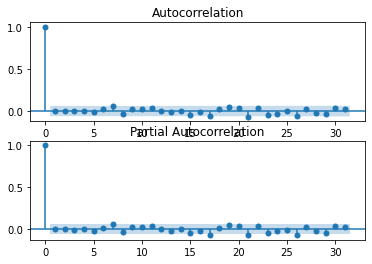

In [33]:
model = sm.tsa.statespace.SARIMAX(ds_method2, order=(1,0,4), seasonal_order = (0,0,1,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res,  ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res,  ax=ax[1])
plt.show()

In [34]:
train = ds_method2.loc['2017-08-01':'2020-01-18']
test = ds_method2.loc['2020-01-19':]
stepwise_model.fit(train)

ARIMA(order=(1, 0, 4), scoring_args={}, seasonal_order=(0, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [35]:
mod = sm.tsa.statespace.SARIMAX(ds_method2,
                                order=(1, 0, 4),
                                seasonal_order=(0, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Steps   No. Observations:                 1043
Model:             SARIMAX(1, 0, 4)x(0, 0, [1], 12)   Log Likelihood               -9976.327
Date:                              Sun, 15 Nov 2020   AIC                          19966.655
Time:                                      00:38:42   BIC                          20001.189
Sample:                                           0   HQIC                         19979.764
                                             - 1043                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9987      0.001    694.529      0.000       0.996       1.002
ma.L1         -0.78

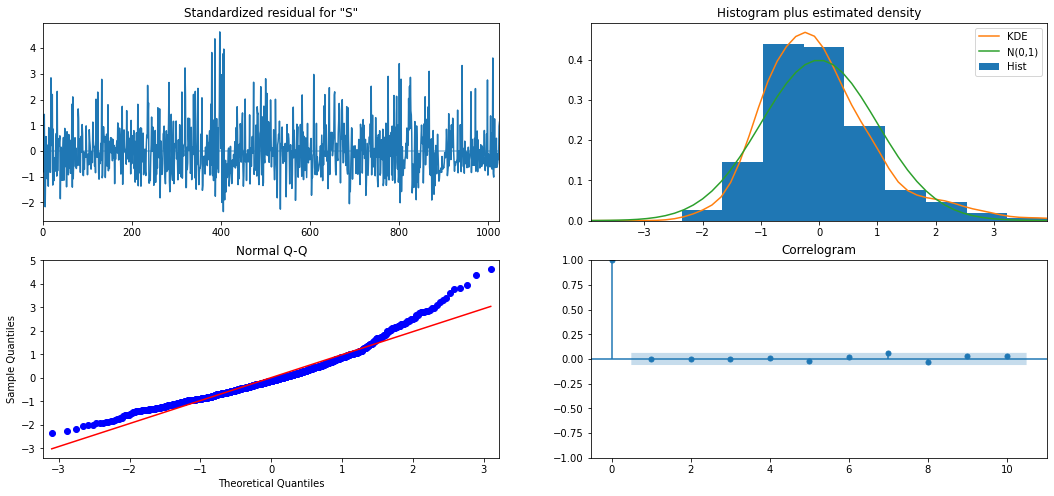

In [36]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [37]:
# the 20% point test data is on the specified date below
split_date = '2020-01-18'
data = ds_method2['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 0, 4),
                                seasonal_order=(0, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [38]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae2 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse2 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse2 = math.sqrt(mse2)
print(f'Mean Squared Error: {mse2.round(4)}')
print(f'Root Mean Squared Error: {round(rmse2,4)}')
print(f'Mean Absolute Error: {mae2.round(4)}')

Mean Squared Error: 24911663.1887
Root Mean Squared Error: 4991.1585
Mean Absolute Error: 4374.4689


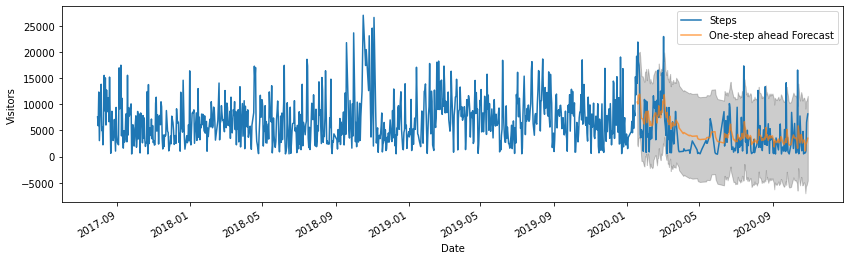

In [39]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-18'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method2['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Visitors')
plt.legend()
plt.show()

# Method 3

In [40]:
#method_1.set_index('Date',inplace=True)
ds_method3.set_index('Date',inplace=True)

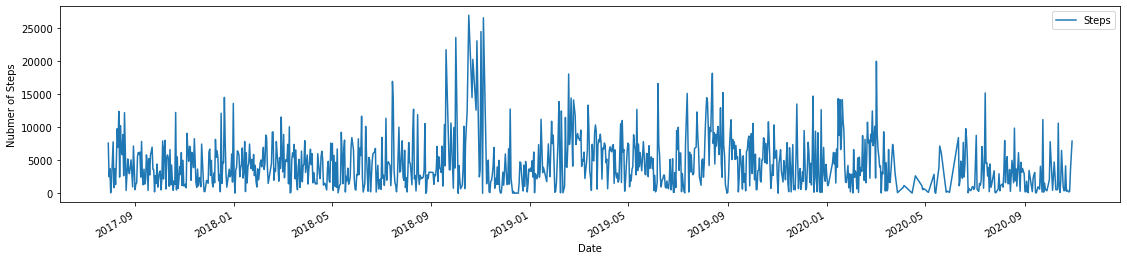

In [41]:
ds_method3.plot(figsize=(19, 4))
plt.ylabel("Nubmer of Steps")
plt.show()

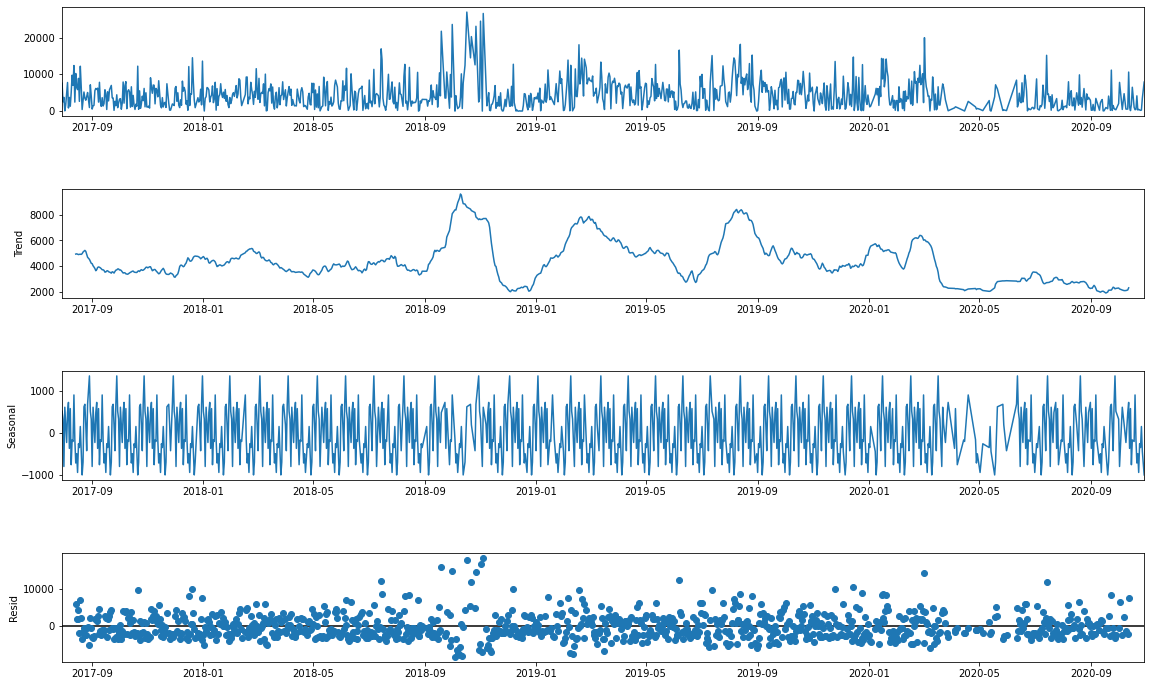

In [42]:
decomposition = sm.tsa.seasonal_decompose(ds_method3, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

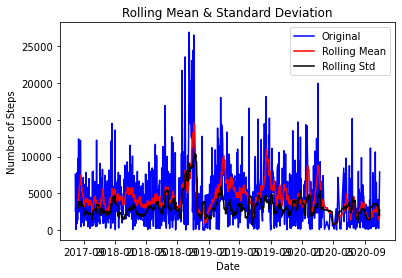

Results of Dickey Fuller Test:
ADF Test Statistic               -4.636954
p-value                           0.000110
#Lags Used                       19.000000
Number of Observations Used    1023.000000
Critical Value (1%)              -3.436758
Critical Value (5%)              -2.864369
Critical Value (10%)             -2.568276
dtype: float64


In [43]:
test_stationarity(ds_method3)

In [44]:
#Estimating trend
#ds_method3 = np.log(ds_method3)
#plt.plot(ds_method3)

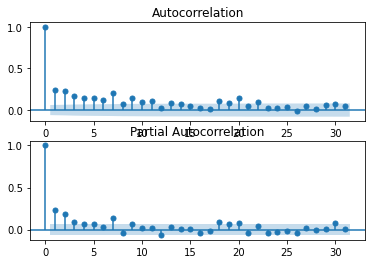

In [45]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method3,  ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method3,  ax=ax[1])
plt.show()

In [48]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(ds_method3, start_p=0, start_q=0,
                           max_p=2, max_q=3, m=12,
                           start_P=0,start_Q=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=20146.222, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=20089.322, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=20107.277, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=21041.362, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=20087.694, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=20089.242, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=20091.236, Time=0.51 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=20053.258, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=20053.569, Time=0.28 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=20053.459, Time=0.19 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=20055.425, Time=0.71 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=20051.713, Time=0.12 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=20050.792, Time=0.37 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=20052.605, Time=0.98 sec
 ARIM

Optimization terminated successfully.
         Current function value: 9.602949
         Iterations: 3
         Function evaluations: 352


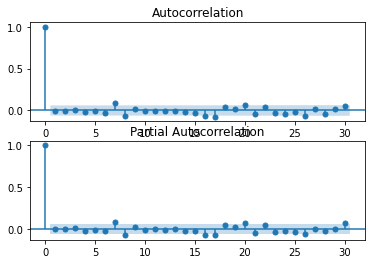

In [49]:
model = sm.tsa.statespace.SARIMAX(ds_method3, order=(2,0,3), seasonal_order = (2,0,2,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=30, ax=ax[1])
plt.show()

In [50]:
train = ds_method3.loc['2017-08-01':'2020-01-18']
test = ds_method3.loc['2020-01-19':]
stepwise_model.fit(train)

ARIMA(order=(2, 0, 3), scoring_args={}, seasonal_order=(2, 0, 2, 12),
      suppress_warnings=True)

In [51]:
mod = sm.tsa.statespace.SARIMAX(ds_method3,
                                order=(2, 0, 3),
                                seasonal_order=(2, 0, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                   Steps   No. Observations:                 1043
Model:             SARIMAX(2, 0, 3)x(2, 0, [1, 2], 12)   Log Likelihood               -9745.120
Date:                                 Sun, 15 Nov 2020   AIC                          19510.240
Time:                                         00:41:36   BIC                          19559.467
Sample:                                              0   HQIC                         19528.936
                                                - 1043                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0655      0.350      3.043      0.002       0.379       1

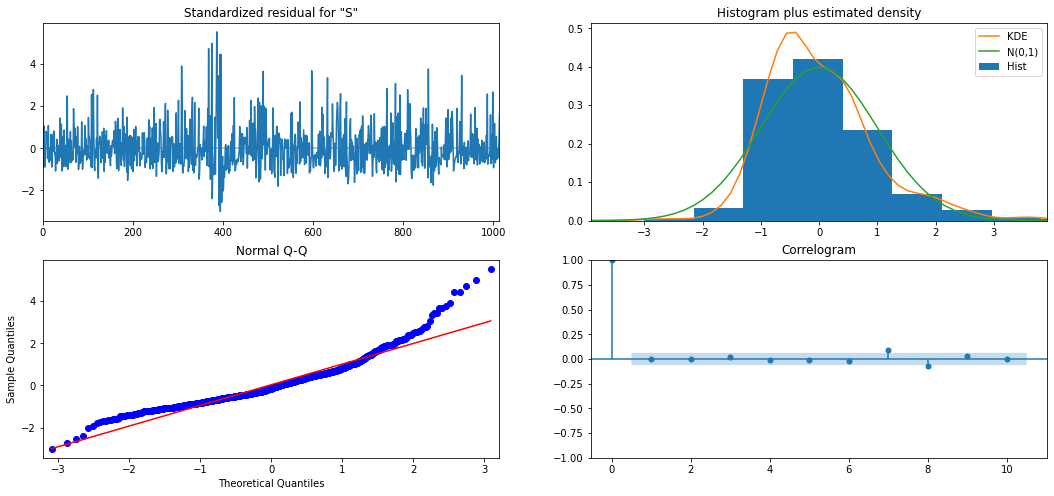

In [52]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [54]:
# the 20% point test data is on the specified date below
split_date = '2020-01-18'
data = ds_method3['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(2,0,3),
                                seasonal_order=(2, 0, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [55]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae3 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse3 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse3 = math.sqrt(mse3)
print(f'Mean Squared Error: {mse3.round(4)}')
print(f'Root Mean Squared Error: {round(rmse3,4)}')
print(f'Mean Absolute Error: {mae3.round(4)}')

Mean Squared Error: 12952944.8289
Root Mean Squared Error: 3599.02
Mean Absolute Error: 3079.5428


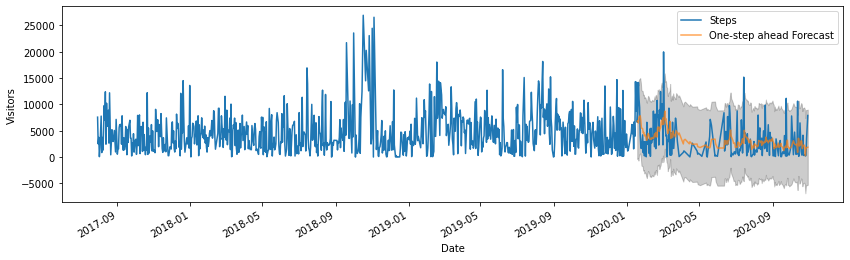

In [56]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-18'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method3['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Visitors')
plt.legend()
plt.show()

In [57]:
models = pd.DataFrame({
    'Method': ['Method 1', 'Method 2', 'Method 3'],
    'MSE': [round(mse1, 4), round(mse2, 4), round(mse3,4)],
    'RMSE': [round(rmse1,4 ), round(rmse2, 4), round(rmse3,4)],
    'MAE': [round(mae1, 4), round(mae2, 4), round(mae3,4)]})
models

,Method,MSE,RMSE,MAE
0,Method 1,2.689178e+07,5185.7286,4410.0606
1,Method 2,2.491166e+07,4991.1585,4374.4689
2,Method 3,1.295294e+07,3599.0200,3079.5428


Models 1 and 3 perform better in certain months than others with Model 2 performing the worst among the three (3). Overall however, Model 3 appears to have the lowest RMSE value. As such, I feel Model 3 Performed the best here